# Lab 6: Transformers - Part 1

ChatGPT was released in 2022 and greatly increased the exposure of Large Language Models (LLMs), and they're capabilities, to the world. In this lab, you are going to implement some of the key parts of the Transformer architecture, which is the architecture that is used for modern LLMs. In the next lab, you will use these components and finish writing an entire transformer that will generate responses to movie dialogues.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import os
import re
import numpy as np
import matplotlib.pyplot as plt

# Section 0: Sequence Modeling and Embeddings

Previously in this course we covered neural networks and convolutional neural networks. Both can be used to extract features from data, and gradually reduce the size of the features to more easily enable tasks like classification. But what if we want the neural network to output something that looks like the data that was inputted? Specifically, sometimes we want to take in a sequence of data parametrized by time or order and output a different sequence. 

![](./images/sequence.png)

Today, the state-of-the-art model for this is the Transformer. Before we dive into it, we will cover some basics on sequence modeling.

Just like we can represent images with pixels, we can represent words as tokens. A token is an integer that represents a specific word or a part of a word. We take some fixed vocabulary size, and tokenize the entire training dataset so any word in the dataset can be represented by an integer.

Just like how in a convolutional neural network we turn pixels into feature vectors that embed some information about the pixels, we convert each token to an embedding vector that is some higher-dimension representation of the word. We need to learn an embedding matrix to achieve this, and we can specify the size of the word embedding to be anything we want. Representing words as embeddings helps the transformer reason about them better. 

![](./images/embeddings.png)

We also get the model to output a vector of the size of our vocabulary, so that after applying a softmax, we can see what's the highest probability token.

# Section 1: Attention

Attention is the core mechanism of a Transformer. This is why the original Transformer paper was called ["Attention Is All You Need"](https://arxiv.org/abs/1706.03762).

When trying to reason about a sentence, it's important to consider how words in a sentence might be related. Attention is a way for the model to "pay attention" to certain words in relation to others. To take a sentence and then figure out what's worth paying attention to, we use the Query-Key-Value formulation.

Consider the following example of image search:

![](./images/query-key-value.png)

We can search for what value is the most relevant to the query by comparing the query to the keys that are associated with each value. Going back to our sentence, if we want to compare words within the same sentence to determine what words are worth attending to, we use self-attention, where the queries, keys, and values all come from the same sequence. Then, we can evaluate how similar the queries and keys are, and then relatively "amplify" the values of the words where the queries and keys are more aligned. This allows the model to consider words that are most similar to each other over words that aren't. Mathematically, we can do this with the attention formula:

$$Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_{query}}})V$$

$Q$ is the query and has the shape ```(batch_size, seq_length, d_query)```. Just like in previous labs, we process entire batches of inputs at a time so the first dimension is the size of the batch. seq_length is the number of words in the input, which can also be thought of as the length of the sequence. d_query is the dimension of the query embedding, meaning that the query is represented by a vector of length d_query.

$K$ is the key and has the shape ```(batch_size, seq_length, d_query)```. The reason d_query is used here is so when comparing keys and queries, they align on the last dimension and their similarities can be computed.

$V$ is the value and has the shape ```(batch_size, seq_length, d_value)```. d_value is not necessarily the same as d_query, because we might want to represent the values as vectors of a different size. However, in this lab, they happen to be the same.

Matrix multiplying $Q$ and $K^T$ effectively gives us the dot product of every query vector with every key vector. Recall that the dot product tells us how close two vectors align, and can be thought of as a quantitative measure for how similar two vectors are. Thus, $QK^T_{ij}$ tells us how similar query $i$ is to key $j$. We want this similarity to be normalize, so we use cosine similarity, which is why we divide by $\sqrt{d_{query}}$. We apply softmax to each row to get the attention map. Then, row $i$ of the attention map sums to 1 and is a weighting on how similar word $i$ is to every the word in the input sequence. 

![](./images/attention.png)

Implement ```scaled_dot_product_attention_without_mask``` following the comments.

In [2]:
def scaled_dot_product_attention_without_mask(query, key, value):
  #matrix multiply Q and K^T
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # get d_query and cast it as tf.float32
  d_query = tf.cast(tf.shape(query)[-1], tf.float32)

  # compute the logits of the attention map
  # remember to divide by sqrt(d_query)
  logits = matmul_qk / tf.math.sqrt(d_query)

  # apply softmax using tf.nn.softmax to the last axis of logits
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # apply the attention map to V
  output = tf.matmul(attention_weights, value)

  return output

In [3]:
# test scaled_dot_product_attention_without_mask
tf.random.set_seed(1234)

batch_size = 2
seq_length = 3
d_embedding = 8
d_query = 4
d_key = 4
d_value = 4

input = tf.random.uniform((batch_size, seq_length, d_embedding))

w_Q = tf.random.uniform((d_embedding, d_query))
w_K = tf.random.uniform((d_embedding, d_key))
w_V = tf.random.uniform((d_embedding, d_value))

Q = tf.matmul(input, w_Q)
K = tf.matmul(input, w_K)
V = tf.matmul(input, w_V)

attn_output = scaled_dot_product_attention_without_mask(Q, K, V)

attn_output_solution = tf.constant(
  [[[2.6964214, 1.8722955, 2.0356367, 1.7275454],
  [2.7064402, 1.8726325, 2.0396535, 1.7393928],
  [2.7179503, 1.8745576, 2.0401611, 1.7443812]],

 [[2.1098378, 1.5404547, 1.986176,  1.5552578],
  [2.1509454, 1.5733178, 2.0266113, 1.5916135],
  [2.138824,  1.5617981, 2.013477,  1.5796201]]])

print(attn_output)
assert(tf.norm(attn_output_solution - attn_output) < 1e-2)


tf.Tensor(
[[[2.6964216 1.8722957 2.035637  1.7275455]
  [2.7064402 1.8726323 2.0396535 1.7393928]
  [2.71795   1.8745575 2.040161  1.744381 ]]

 [[2.109838  1.540455  1.9861764 1.555258 ]
  [2.1509457 1.5733178 2.0266116 1.5916137]
  [2.138824  1.5617982 2.013477  1.57962  ]]], shape=(2, 3, 4), dtype=float32)


# Section 2: Masking

Sometimes, we don't want our transformer to do anything anything with certain tokens in the input. Before taking the softmax in the attention mechanism, we set any part of the attention map we don't want the transformer to consider to negative infinity. 

### Section 2.1: Padding Masking

When we define inputs or outputs for the transformer, they'll have a sequence length of ```max_length```. So if we input a sentence that has less tokens than max_length, we will pad the rest of the sequence with a special pad token represented by 0. In the attention mechanism, we want to ignore these pad tokens. 

Before we take the softmax to make the attention map, we will have shape ```(batch_size, num_heads, max_length, max_length)``` (we will describe num_heads later in multi-head attention). 

We want to create a mask where every element of the mask that is 1 should become negative infinity and every element of the mask that is 0 will stay the same. 

Thus, we will create a mask of shape ```(batch_size, 1, 1, max_length)``` which will broadcast over the second and third dimension of ```(batch_size, num_heads, max_length, max_length)```. 

Implement ```create_padding_mask``` using the comments.

### Section 2.2: Look Ahead Masking

The transformer we will train is autoregressive. 

This means it predicts the next token from the tokens its already predicted in the past. During inference (generation), we give the model a special start token, and then in a loop, it predicts the next words, appends it to the current sentence, and repeats, until it predicts a special end token. 

During training we already have the output which is the input but shifted to the left by one token (see image below). If the decoder takes in $n$ tokens, it must also output $n$ tokens.

![](./images/output_shift.png)

However, during training, we don't want to compute attention between the $i$-th token and any token $> i$, i.e. in the future. That way, the $i$-th output token is what the transformer would output if it only saw (and applied attention to) the first $i$ input tokens. 

To prevent the transformer from "looking ahead" in the attention, we use a mask that is 1 where we want the transformer to ignore the attention map and 0 where its alright to apply attention. Specifically, the mask is:
$$m_{ij} =
  \begin{cases} 
      1 & i < j \\
      0 & i \geq j \\ 
   \end{cases}\\$$
and has the shape ```(batch_size, 1, max_length, max_length)``` as it will broadcast over the num_heads dimension. 
Since the output of softmax approaches 0 as the input approaches negative infinity, we multiply the mask by some large negative number.

![](./images/look_ahead_masking.png)

We also want to make sure that pad tokens are masked out in this mask as well. 

Implement ```create_look_ahead_mask``` using the comments.

### Section 2.3: Attention with Mask

Now that we have these two kinds of masks, we need to change our attention method to use the mask. 

Remember that we want to set values of the mask that are 1 to negative infinity, before the attention map is passed to the softmax. That way, the masked values will become zero after the softmax and the transformer won't "pay any attention" to them. 

Implement ```scaled_dot_product_attention``` using the comments.


In [4]:
def create_padding_mask(x):
  # create the padding mask which is a boolean tensor
  # 1 where the tokens are 0, 0 otherwise
  # Hint: tf.math.equal
  mask = tf.math.equal(x, 0)

  # cast the mask as tf.float32
  mask = tf.cast(mask, tf.float32)

  # the mask is currently of shape (batch_size, max_length)
  # give it the shape (batch_size, 1, 1, max_length)
  mask = tf.expand_dims(tf.expand_dims(mask, axis=1), axis=1)

  return mask

def create_look_ahead_mask(x):
  # x is of shape (batch_size, max_length)
  # get max_length
  max_length = tf.shape(x)[1]

  # create the look ahead mask using tf.linalg.band_part and tf.ones
  # refer to the formula for the mask above: want only 1s above the diagonal
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((max_length, max_length)), -1, 0)
  look_ahead_mask = tf.cast(look_ahead_mask, tf.float32)  # shape: (max_length, max_length)

  # NOT NORMAL: expand dims to make shape (1, 1, max_length, max_length) so it can broadcast
  look_ahead_mask = tf.expand_dims(tf.expand_dims(look_ahead_mask, axis=0), axis=1)

  # use create_padding_max to get the padding mask of x
  padding_mask = create_padding_mask(x)

  # combine the look_ahead_mask and the padding_mask
  # Hint: use tf.maximum
  look_ahead_mask = tf.maximum(look_ahead_mask, padding_mask)

  return look_ahead_mask

def scaled_dot_product_attention(query, key, value, mask):
  #matrix multiply Q and K^T
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # get d_query and cast it as tf.float32
  d_query = tf.cast(tf.shape(query)[-1], tf.float32)

  # compute the logits of the attention map
  # remember to divide by sqrt(d_query)
  logits = matmul_qk / tf.math.sqrt(d_query)

  # multiply the mask by a large negative number (-1e9) and add it to logits
  # this effectively makes masked values negative infinity
  if mask is not None:
    logits += (mask * -1e9)

  # apply softmax using tf.nn.softmax to the last axis of logits
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # apply the attention map to V
  output = tf.matmul(attention_weights, value)

  return output

In [5]:
# test create_padding_mask
tf.random.set_seed(1234)

batch_size = 1
max_length = 5

input = np.random.randint(1, 10, (batch_size, max_length))
input[0][2] = 0
input = tf.convert_to_tensor(input)

padding_mask = create_padding_mask(input)
print(padding_mask)

padding_mask_solution = tf.constant([[0, 0, 1, 0, 0]], dtype=tf.float32)

assert(tf.norm(padding_mask - padding_mask_solution) < 1e-2)


tf.Tensor([[[[0. 0. 1. 0. 0.]]]], shape=(1, 1, 1, 5), dtype=float32)


In [6]:
# test create_look_ahead_mask
look_ahead_mask = create_look_ahead_mask(input)
print(look_ahead_mask)

look_ahead_mask_solution = tf.constant(
[[[[0, 1, 1, 1, 1],
   [0, 0, 1, 1, 1],
   [0, 0, 1, 1, 1],
   [0, 0, 1, 0, 1],
   [0, 0, 1, 0, 0]]]], dtype=tf.float32)

assert(tf.norm(look_ahead_mask - look_ahead_mask_solution) < 1e-2)

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [7]:
# test scaled_dot_product_attention
tf.random.set_seed(1234)

batch_size = 2
seq_length = 5
d_embedding = 8
d_query = 2
d_key = 2
d_value = 2

input = tf.random.uniform((batch_size, seq_length, d_embedding))

w_Q = tf.random.uniform((d_embedding, d_query))
w_K = tf.random.uniform((d_embedding, d_key))
w_V = tf.random.uniform((d_embedding, d_value))

Q = tf.matmul(input, w_Q)
K = tf.matmul(input, w_K)
V = tf.matmul(input, w_V)

attn_output = scaled_dot_product_attention(Q, K, V, look_ahead_mask_solution)

attn_output_solution = tf.constant(
  [[[[1.9943544, 1.3863453],
   [1.902195,  1.5321324],
   [1.9024689, 1.5316987],
   [1.8435459, 1.4898659],
   [1.8339779, 1.5064971]],
  [[1.8489847, 1.0564694],
   [1.7953603, 1.199664 ],
   [1.7964938, 1.1966374],
   [2.4567406, 1.6503923],
   [2.383724,  1.6358945]]]])

print(attn_output)
assert(tf.norm(attn_output_solution - attn_output) < 1e-2)



tf.Tensor(
[[[[1.9943542 1.3863453]
   [1.9021947 1.5321323]
   [1.9024688 1.5316987]
   [1.8435457 1.4898659]
   [1.8339779 1.5064973]]

  [[1.8489847 1.0564694]
   [1.7953604 1.1996641]
   [1.7964938 1.1966373]
   [2.4567404 1.6503923]
   [2.3837242 1.6358948]]]], shape=(1, 2, 5, 2), dtype=float32)


# Section 3: Multi-Head Attention

The original transformer paper, "Attention Is All You Need", proposed to use multi-head attention (MHA). 

For every Q, K, and V, the attention is split among ```num_heads``` heads. This allows for better expression and attending to multiple things at once. 

HMA takes in the sequence used for the queries, keys, and values (note that the sequence used for the queries can be different than the sequence used for the keys and values). 

Let's say $q$ is the query inputs, $k$ is the key inputs, and $v$ is the value inputs and each of them has shape ```(batch_size, max_length, d_embedding)```. 

We apply learned weight matrices, $W_Q$, $W_K$, $W_V$, of shapes ```(d_embedding, d_query)```, ```(d_embedding, d_key)```, ```(d_embedding, d_value)``` to $q, k, v$ so we get $Q = qW_Q, K = kW_k, V = kW_v$ with shapes ```(batch_size, max_length, d_query)```, ```(batch_size, max_length, d_key)```, ```(batch_size, max_length, d_value)```. 

In Multi-Head attention, we split $Q, K, V$ along the $d_{query}/d_{key}/d_{value}$ dimension into ```num_heads``` different pieces (heads). So after we split $Q$, it will have shape ```(batch_size, num_heads, max_length, d_key//num_heads)```. Notice that the number of elements didn't change since we divided the last dimension by the number of heads. 

After we perform attention on the split $Q, K, V$ (which works due to broadcasting), we concatenate the outputs back together to get the shape ```(batch_size, max_length, d_value)```. We finish with one last dense layer.

Refer to the image below for a visual explanation. Implement parts of the class ```MultiHeadAttention```.

![](./images/multi-head-attention.png)


In [8]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    # number of heads we will split Q, K, V into
    self.num_heads = num_heads

    # d_model = d_query = d_key = d_value
    self.d_model = d_model

    # d_model needs to be divisible by the number of heads so the split is even
    assert d_model % self.num_heads == 0

    # We will represent W_Q, W_K, W_V as dense layers because we want to learn them.
    # Recall that dense layers are specified by the number of outputs.
    # Since W_Q has shape (d_embedding, d_model), specify the number of units for
    # each dense layer accordingly.
    self.query_dense = tf.keras.layers.Dense(d_model)
    self.key_dense = tf.keras.layers.Dense(d_model)
    self.value_dense = tf.keras.layers.Dense(d_model)

    # MHA has a final dense layer applied to the output of attention
    # the number of outputs is also d_model for this.
    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, inputs, batch_size):
    # Inputs has shape (batch_size, max_length, d_model)
    # Reshape it to have shape (batch_size, max_length, num_heads, d_model//num_heads)
    # Notice that we don't explicitly have max_length, but that you can use -1
    # to "fill in" missing dimensions when reshaping
    inputs = tf.reshape(inputs, (batch_size, -1, self.num_heads, self.d_model//self.num_heads))
    
    # Transpose inputs to have shape (batch_size, num_heads, max_length, d_model//num_heads)
    inputs = tf.transpose(inputs, perm=[0, 2, 1, 3])

    return inputs

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # call the corresponding dense layer on the inputs for query, key, and value
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # use the split_heads method to split the query, key and value
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # call scaled_dot_product_attention, remember to use the mask
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    # currently scaled_attention has shape (batch_size, num_heads, max_length, d_model//num_heads)
    # transpose it to be (batch_size, max_length, num_heads, d_model//num_heads)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenate the heads so that scaled_attention has shape (batch_size, max_length, d_model)
    # note that you can just use tf.reshape for this
    concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

    # call the final dense layer on concat_attention
    outputs = self.dense(concat_attention)

    return outputs

In [9]:
# test Multi Head Attention
tf.keras.utils.set_random_seed(1234)

batch_size = 2
seq_length = 3
d_model = 4
num_heads = 2

input_tokens = np.random.randint(1, 10, (batch_size, seq_length))
input_tokens[0][2] = 0
input_tokens = tf.convert_to_tensor(input_tokens)
print(input_tokens)

look_ahead_mask = create_look_ahead_mask(input_tokens)

input_embeddings = tf.keras.layers.Embedding(10, d_model)(input_tokens)

input = {"query": input_embeddings, "key": input_embeddings, "value": input_embeddings, "mask": look_ahead_mask}

mha = MultiHeadAttention(d_model, num_heads)

mha_output = mha(input)
print(mha_output)

mha_output_solution = tf.constant(
[[[ 0.02514083,  0.00977693, -0.00337918,  0.00960296],
  [ 0.01701181,  0.01394134, -0.01645077, -0.01413145],
  [ 0.0170159,   0.0139411,  -0.01644699, -0.01411536]],

 [[ 0.01959381,  0.00368656, -0.00541761,  0.0188225 ],
  [ 0.00100767, -0.00967453,  0.00965437,  0.01981302],
  [ 0.00328764,  0.0039839,  -0.00588427, -0.01156338]]], dtype=tf.float32)

assert(tf.norm(mha_output_solution - mha_output) < 1e-2)

tf.Tensor(
[[4 7 0]
 [5 9 2]], shape=(2, 3), dtype=int32)
tf.Tensor(
[[[ 0.02514083  0.00977693 -0.00337918  0.00960296]
  [ 0.01701181  0.01394134 -0.01645077 -0.01413144]
  [ 0.0170159   0.0139411  -0.01644699 -0.01411536]]

 [[ 0.01959381  0.00368656 -0.00541761  0.0188225 ]
  [ 0.00100767 -0.00967453  0.00965437  0.01981302]
  [ 0.00328764  0.0039839  -0.00588428 -0.01156338]]], shape=(2, 3, 4), dtype=float32)


# Section 4: Positional Encoding

Attention is permutation invariant, meaning that no matter what order the words are in, the similarities between the words won't be different. But the order of the words in a sentence matters a lot! How can we adjust the inputs to the transformer so that the attention mechanism considers the order of the words? We can use positional embeddings.

When constructing our input to the transformer, we apply a learned embedding layer to the tokens to turn the tokens into feature vectors. Then we add a positional embedding, element-wise, to each feature vector that should help give the feature vector a relative order to the other feature vectors. Then, words that are closer together will be considered more similar by the attention mechanism.

The formula for calculating positional encoding is:

$$PE_{t, 2i} = sin(t/10000^{2i/d_{model}})$$
$$PE_{t, 2i+1} = cos(t/10000^{2i/d_{model}})$$

I won't go into detail here, but to understand why this formula achieves what we want, please read [this article.](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/#the-intuition)

Implement the ```PositionalEncoding``` class. If you implement it correctly, your graph visualizing the positional encoding should look like this:

![](./images/positional_encoding.png)

Notice how each row of the graph, demonstrating the positional encoding for a certain position, can be differentiated from rows far away. Adding this to the input sequence gives each feature vector a relative order. 


In [10]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, max_position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(max_position, d_model)

  def get_angles(self, positions, inds, d_model):
    # compute the angle that is input to either sine or cosine later
    # make sure you cast d_model as a tf.float32 in the expression
    angles = 1 / tf.pow(10000.0, (2 * (inds // 2)) / tf.cast(d_model, tf.float32))
    return positions * angles

  def positional_encoding(self, max_position, d_model):
    # get the range of positions that we need to compute positional encodings for
    # use tf.range and ensure it has type tf.float32
    # also add a dimension so the shape is (max_position, 1), this will be useful for broadcasting
    positions = tf.cast(tf.range(max_position)[:, tf.newaxis], tf.float32)        # shape (max_position, 1)
    
    # get the range of feature indicies
    # note that the feature vector has length d_model
    # use tf.range and ensure it has type tf.float32
    # also add a dimension so the shape is (1, d_model), this will be useful for broadcasting
    feature_inds = tf.cast(tf.range(d_model)[tf.newaxis, :], tf.float32)          # shape (1, d_model)

    # get the angles using the get_angles method
    angle_rads = self.get_angles(positions, feature_inds, d_model)
    
    # apply sin to every even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])

    # apply cos to every odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # concatenate sines and cosines along the last (feature) dimension
    pos_encoding = tf.concat([sines, cosines], axis=-1)

    # add an extra first dimension so the shape is (1, max_position, d_model)
    # this will be useful for broadcasting across the batch
    pos_encoding = (pos_encoding[:, :d_model])[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding

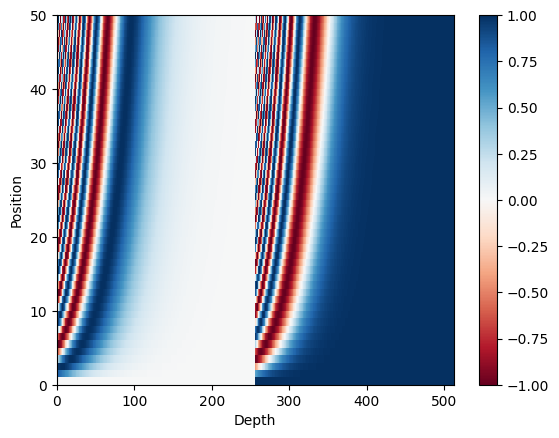

In [11]:
# graph positional encodings
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In the next lab, we'll take all the components you built here, and put them all into a transformer architecture that you will use to train a transformer that can respond to movie dialogues. 